In [1]:
from scipy.optimize import minimize
import numpy as np
from scipy.stats import norm, norminvgauss
import numpy as np
import pandas as pd
import scipy.optimize as opt
from statsmodels import regression
import statsmodels.formula.api as sm
from scipy.stats import norm, norminvgauss
from numba import jit, njit, prange, float64, int64
import numpy as np
import pandas as pd
import scipy.optimize as opt
from statsmodels import regression
import statsmodels.formula.api as sm
from numba import jit, njit, prange, float64, int64
import yfinance as yf
import matplotlib.pyplot as plt
import warnings

# Ignorer les RuntimeWarnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
import time

In [3]:
from tqdm import tqdm

In [4]:
kbar = 5
def simulatedata(b,m0,gamma_kbar,delta, alpha, kbar, T):
    m0 = m0
    m1 = 2-m0
    g_s = np.zeros(kbar)
    M_s = np.zeros((kbar,T))
    g_s[0] = 1-(1-gamma_kbar)**(1/(b**(kbar-1)))
    for i in range(1,kbar):
        g_s[i] = 1-(1-g_s[0])**(b**(i))
    for j in range(kbar):
        M_s[j,:] = np.random.binomial(1,g_s[j],T)
    dat = np.zeros(T)
    tmp = (M_s[:,0]==1)*m1+(M_s[:,0]==0)*m0
    dat[0] = np.prod(tmp)
    for k in range(1,T):
        for j in range(kbar):
            if M_s[j,k]==1:
                tmp[j] = np.random.choice([m0,m1],1,p = [0.5,0.5])
        dat[k] = np.prod(tmp)
    
    #dat = np.sqrt(dat)*sig* np.random.normal(size = T) norminvgauss.rvs(1,0, loc=0, scale=kuezeufe)   # VOL TIME SCALING
    data_1 = np.array([norminvgauss.rvs(alpha*dat[k]*delta, 0, loc=0, scale=dat[k]*delta) for k in range (len(dat))])
    data_1 = data_1.reshape(-1,1)
    return(data_1)
def glo_min(kbar, data, niter, temperature, stepsize):
    """2-step basin-hopping method combines global stepping algorithm
       with local minimization at each step.
    """

    """step 1: local minimizations
    """
    theta, theta_LLs, theta_out, ierr, numfunc = loc_min(kbar, data)

    """step 2: global minimum search uses basin-hopping
       (scipy.optimize.basinhopping)
    """
    # objective function
    f = g_LLb_h

    # x0 = initial guess, being theta, from Step 1.
    # Presents as: [b, m0, gamma_kbar, sigma] b,m0,gamma_kbar,delta, alpha
    x0 = theta

    # basinhopping arguments
    niter = niter
    T = temperature
    stepsize = stepsize
    args = (kbar, data)

    # bounds
    bounds = ((1.001,50),(1,1.99),(1e-3,0.999999),(1e-5,5), (1, 50))

    # minimizer_kwargs
    minimizer_kwargs = dict(method = "L-BFGS-B", bounds = bounds, args = args)

    res = opt.basinhopping(
                func = f, x0 = x0, niter = niter, T = T, stepsize = stepsize,
                minimizer_kwargs = minimizer_kwargs)

    parameters, LL, niter, output = res.x,res.fun,res.nit,res.message

    return(parameters, LL, niter, output)

def estim_delta_alpha(data):
    a = np.mean(data**2)
    b = np.mean(data**4)
    alph = (3*a/(b-3*a**2))**(1/2) #alpha 
    delt = (3*a/(b-3*a**2))**(1/2)*a
    return [delt, alph]

def loc_min(kbar, data):
    """step 1: local minimization
       parameter estimation uses bounded optimization (scipy.optimize.fminbound)
    """

    # set up
    b = np.array([1.5, 5, 15, 30])
    lb = len(b)
    gamma_kbar = np.array([0.1, 0.5, 0.9, 0.95])
    lg = len(gamma_kbar)
    est =  estim_delta_alpha(data)
    delta = est[0]
    alpha = est[1]
    #a = np.mean(data**2)
    #b = np.mean(data**4)
    #alpha = (3*a/(b-3*a**2))**(1/2) #alpha 
    #delta = (3*a/(b-3*a**2))**(1/2)*a # delta

    # templates
    theta_out = np.zeros(((lb*lg),3))
    theta_LLs = np.zeros((lb*lg))

    # objective function
    f = g_LL

    # bounds
    m0_l = 1.2
    m0_u = 1.8

    # Optimizaton stops when change in x between iterations is less than xtol
    xtol = 1e-05

    # display: 0, no message; 1, non-convergence; 2, convergence;
    # 3, iteration results.
    disp = 1

    idx = 0
    for i in range(lb):
        for j in range(lg):

            # args
            theta_in = [b[i], gamma_kbar[j], delta, alpha]
            args = (kbar, data, theta_in)

            xopt, fval, ierr, numfunc = opt.fminbound(
                        func = f, x1 = m0_l, x2 = m0_u, xtol = xtol,
                        args = args, full_output = True, disp = disp)

            m0, LL = xopt, fval
            theta_out[idx,:] = b[i], m0, gamma_kbar[j]

            theta_LLs[idx] = LL
            idx +=1

    idx = np.argsort(theta_LLs)

    theta_LLs = np.sort(theta_LLs)

    theta = theta_out[idx[0],:].tolist()+[delta,alpha]
    theta_out = theta_out[idx,:]

    return(theta, theta_LLs, theta_out, ierr, numfunc)


def g_LL(m0, kbar, data, theta_in):
    """return LL, the vector of log likelihoods
    """
    #b,m0,gamma_kbar,delta, alpha
    # set up
    b = theta_in[0]
    gamma_kbar = theta_in[1]
    delta = theta_in[2]
    alpha = theta_in[3]
    kbar2 = 2**kbar
    T = len(data)
    pa = (2*np.pi)**(-0.5)

    # gammas and transition probabilities
    A = g_t(kbar, b, gamma_kbar)

    # switching probabilities
    g_m = s_p(kbar, m0)

    # volatility model
    s = delta*g_m

    # returns
    w_t = data
    w_t = norminvgauss(alpha*s, 0, loc=0, scale=s).pdf(w_t) ;
    w_t = w_t + 1e-16

    # log likelihood using numba
    LL = _LL(kbar2, T, A, g_m, w_t)

    return(LL)


@jit(nopython=True)
def _LL(kbar2, T, A, g_m, w_t):
    """speed up Bayesian recursion with numba
    """

    LLs = np.zeros(T)
    pi_mat = np.zeros((T+1,kbar2))
    pi_mat[0,:] = (1/kbar2)*np.ones(kbar2)

    for t in range(T):

        piA = np.dot(pi_mat[t,:],A)
        C = (w_t[t,:]*piA)
        ft = np.sum(C)

        if abs(ft-0) <= 1e-05:
            pi_mat[t+1,1] = 1
        else:
            pi_mat[t+1,:] = C/ft

        # vector of log likelihoods
        LLs[t] = np.log(np.dot(w_t[t,:],piA))

    LL = -np.sum(LLs)

    return(LL)


def g_pi_t(m0, kbar, data, theta_in):
    """return pi_t, the current distribution of states
    """

    # set up
    b = theta_in[0]
    gamma_kbar = theta_in[1]
    delta = theta_in[2]
    alpha = theta_in[3]
    kbar2 = 2**kbar
    T = len(data)
    pa = (2*np.pi)**(-0.5)
    pi_mat = np.zeros((T+1,kbar2))
    pi_mat[0,:] = (1/kbar2)*np.ones(kbar2)

    # gammas and transition probabilities
    A = g_t(kbar, b, gamma_kbar)

    # switching probabilities
    g_m = s_p(kbar, m0)

    # volatility model
    s = delta*g_m

    # returns
    w_t = data
    w_t = norminvgauss(alpha*s, 0, loc=0, scale=s).pdf(w_t) ;
    w_t = w_t + 1e-16

    # compute pi_t with numba acceleration
    pi_t = _t(kbar2, T, A, g_m, w_t)

    return(pi_t)


@jit(nopython=True)
def _t(kbar2, T, A, g_m, w_t):

    pi_mat = np.zeros((T+1,kbar2))
    pi_mat[0,:] = (1/kbar2)*np.ones(kbar2)

    for t in range(T):

        piA = np.dot(pi_mat[t,:],A)
        C = (w_t[t,:]*piA)
        ft = np.sum(C)
        if abs(ft-0) <= 1e-05:
            pi_mat[t+1,1] = 1
        else:
            pi_mat[t+1,:] = C/ft

    pi_t = pi_mat[-1,:]

    return(pi_t)


class memoize(dict):
    """use memoize decorator to speed up compute of the
       transition probability matrix A
    """
    def __init__(self, func):
        self.func = func

    def __call__(self, *args):
        return self[args]

    def __missing__(self, key):
        result = self[key] = self.func(*key)
        return result

@memoize
def  g_t(kbar, b, gamma_kbar):
    """return A, the transition probability matrix
    """

    # compute gammas
    gamma = np.zeros((kbar,1))
    gamma[0,0] = 1-(1-gamma_kbar)**(1/(b**(kbar-1)))
    for i in range(1,kbar):
        gamma[i,0] = 1-(1-gamma[0,0])**(b**(i))
    gamma = gamma*0.5
    gamma = np.c_[gamma,gamma]
    gamma[:,0] = 1 - gamma[:,0]

    # transition probabilities
    kbar2 = 2**kbar
    prob = np.ones(kbar2)

    for i in range(kbar2):
        for m in range(kbar):
            tmp = np.unpackbits(
                        np.arange(i,i+1,dtype = np.uint16).view(np.uint8))
            tmp = np.append(tmp[8:],tmp[:8])
            prob[i] =prob[i] * gamma[kbar-m-1,tmp[-(m+1)]]

    A = np.fromfunction(
        lambda i,j: prob[np.bitwise_xor(i,j)],(kbar2,kbar2),dtype = np.uint16)

    return(A)


def j_b(x, num_bits):
    """vectorize first part of computing transition probability matrix A
    """

    xshape = list(x.shape)
    x = x.reshape([-1, 1])
    to_and = 2**np.arange(num_bits).reshape([1, num_bits])

    return (x & to_and).astype(bool).astype(int).reshape(xshape + [num_bits])


@jit(nopython=True)
def s_p(kbar, m0):
    """speed up computation of switching probabilities with Numba
    """

    # switching probabilities
    m1 = 2-m0
    kbar2 = 2**kbar
    g_m = np.zeros(kbar2)
    g_m1 = np.arange(kbar2)

    for i in range(kbar2):
        g = 1
        for j in range(kbar):
            if np.bitwise_and(g_m1[i],(2**j))!=0:
                g = g*m1
            else:
                g = g*m0
        g_m[i] = g

    return(np.sqrt(g_m))


def g_LLb_h(theta, kbar, data):
    """bridge global minimization to local minimization
    """

    theta_in = unpack(theta)
    m0 = theta[1]
    LL = g_LL(m0, kbar, data, theta_in)

    return(LL)


def unpack(theta):
    """unpack theta, package theta_in
    """
    b = theta[0]
    m0 = theta[1]
    gamma_kbar = theta[2]
    delta = theta[3]
    alpha = theta[4]
    
    theta_in = [b, gamma_kbar, delta, alpha]

    return(theta_in)

def trajectoires(N,T, data):
    '''
    N nb de trajectoires, 
    T durée sélectionnée pour l'horizon, 
    data = "AAPL" par exemple
    '''
    
    kbar = 5 
    '''
    paramètre du modèle MSM à choisir. correspond au nombres de cycles. Doit être inférieur ou 
    égale à 5 pour des raisons de temps de calculs.
    '''
    Forcast = []
    
    # Formatage des données
    ticker_symbol = data  # Symbole boursier
    start_date = "2022-04-07" # à modifier si besoin
    end_date = "2024-01-08"
    # Récupérer les données historiques
    data = yf.download(ticker_symbol, start=start_date, end=end_date, interval = "60m")
    data['Returns'] = data['Adj Close'].pct_change()
    returns_numpy = data['Returns'].to_numpy()[1:]
    returns_numpy = returns_numpy.reshape(-1,1)
    print(len(returns_numpy))

    
    # Fitting du modèle
    niter = 1
    temperature = 1.0
    stepsize = 1.0
    parameters, LL, niter, output = glo_min(kbar, returns_numpy, niter, temperature, stepsize)
    # parameters contient les valeurs estimées
    # name parameters for later use:
    b_sim = parameters[0]
    m_0_sim = parameters[1]
    gamma_kbar_sim = parameters[2]
    delta_sim = parameters[3]
    alpha_sim = parameters[4]
    LL_sim = LL # valeur au minimum de vraisemblance
    
    for _ in range (N):
        # Valeurs des returns simulés
        returns  = simulatedata(b_sim,m_0_sim,gamma_kbar_sim,delta_sim, alpha_sim, kbar, T).reshape(-1)
        # return défini comme ln(p_t/p_t-1)
        prix = [data['Close'].values[-1]]
        for i in range (T):
            p = np.exp(returns[i])
            prix.append(prix[-1]*p)
        Forcast.append(prix)
    return np.array(Forcast)

def afficher (trajectoires):
    plt.figure(figsize = (20,12))
    T = len(trajectoires[1])
    for i in range (len(trajectoires)):
        Time = np.arange(0, T, 1)
        plt.plot(Time, trajectoires[i])
    plt.xlabel("Time")
    plt.ylabel("Prix")
    plt.title("Simulation d'évolution des prix de l'actif sous jacent")
    plt.show()

[*********************100%***********************]  1 of 1 completed
3062
Number of simulations: 3


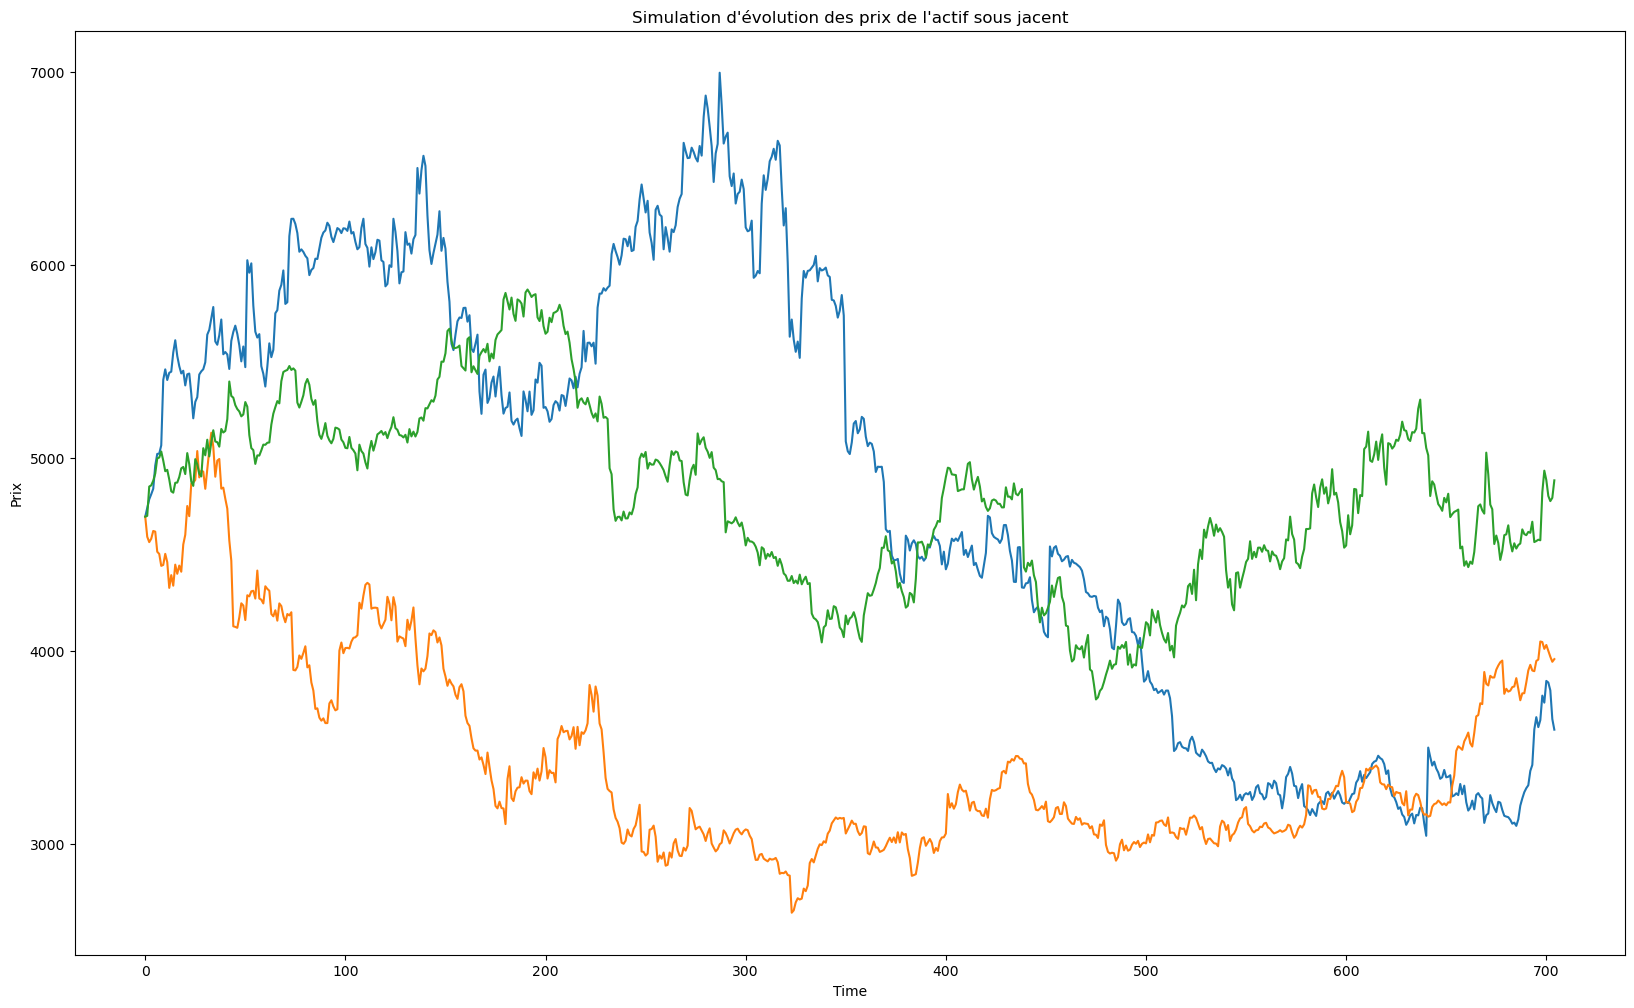

In [5]:
'''
Fonctions importantes : 

---trajectoires(N,T, data) simule N trajectoires de longueur T sur le data qui est un symbole du type "APPL" ---

---afficher(trajectoires) affiche ces trajectoires---

'''

N = 3
T = 352*2
data = "AAPL"
data = "^SPX"
#st = time()
paths = trajectoires(N,T, data)
#et = time()
print(60*'=')
print('Number of simulations: %i' % N)
#print('Time to simulate was %f seconds' % (et-st))
print(60*'=')
afficher(paths)

In [6]:
np.shape(np.array(paths))

(3, 705)

In [7]:
paths[1,1]

4592.5634025494255

synthetic paths

In [8]:
def trajectoires_synth(S0, N,T, data):
    '''
    N nb de trajectoires, 
    T durée sélectionnée pour l'horizon, 
    data = "AAPL" par exemple
    '''
    
    kbar = 5 
    '''
    paramètre du modèle MSM à choisir. correspond au nombres de cycles. Doit être inférieur ou 
    égale à 5 pour des raisons de temps de calculs.
    '''
    Forcast = []
    
    # Formatage des données
    ticker_symbol = data  # Symbole boursier
    start_date = "2022-04-07" # à modifier si besoin
    end_date = "2024-01-08"
    # Récupérer les données historiques
    data = yf.download(ticker_symbol, start=start_date, end=end_date, interval = "60m")
    data['Returns'] = data['Adj Close'].pct_change()
    returns_numpy = data['Returns'].to_numpy()[1:]
    returns_numpy = returns_numpy.reshape(-1,1)
    print(len(returns_numpy))

    
    # Fitting du modèle
    niter = 1
    temperature = 1.0
    stepsize = 1.0
    parameters, LL, niter, output = glo_min(kbar, returns_numpy, niter, temperature, stepsize)
    # parameters contient les valeurs estimées
    # name parameters for later use:
    b_sim = parameters[0]
    m_0_sim = parameters[1]
    gamma_kbar_sim = parameters[2]
    delta_sim = parameters[3]
    alpha_sim = parameters[4]
    LL_sim = LL # valeur au minimum de vraisemblance
    
    for _ in tqdm(range(N)):
        # Valeurs des returns simulés
        returns  = simulatedata(b_sim,m_0_sim,gamma_kbar_sim,delta_sim, alpha_sim, kbar, T).reshape(-1)
        # return défini comme ln(p_t/p_t-1)
        #prix = [data['Close'].values[-1]]
        prix = [S0]
        for i in range (T):
            p = np.exp(returns[i])
            prix.append(prix[-1]*p)
        Forcast.append(prix)
    return np.array(Forcast)

## ================================================================================================================

Special import necessary, regarder le fichier de code BMS 

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from BMS import BMS_price
from time import time
import statistics
# import our polynomial function
from polynomials import constructX
# linear regression
from sklearn.linear_model import LinearRegression

# First potential application - pricing via simulation



In [10]:
# parametres dont on pourra parler

r = 0.025
q = 0.05
    
S = 100
K = 80
sig = 0.3
T = 2

ca il faut regarder ce que ca fait c^'est poru exercicer les options americaines vs les europeennes mais le code en dessous price les deux'

Elapsed time was 36.777211 seconds


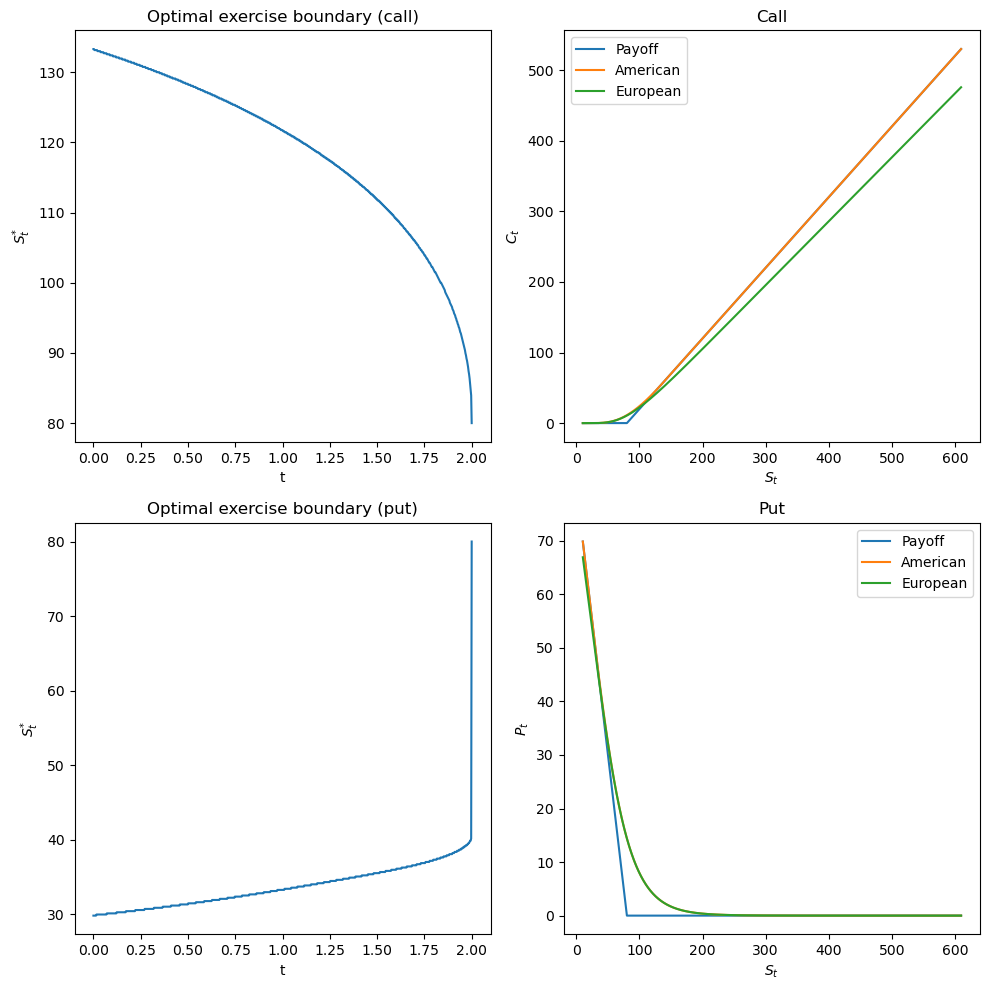

In [11]:
def tridiag_solver(l, d, u, b):
    n = len(b)
    D = np.copy(d)
    B = np.copy(b)
    x = np.zeros(n)
    for i in range(1, n):
        w = l[i] / D[i-1]
        D[i] = D[i] - w*u[i-1]
        B[i] = B[i] - w*B[i-1]
    x[n-1] = B[n-1]/D[n-1]
    for i in range(n-2, -1, -1):
        x[i] = (B[i] - u[i]*x[i+1])/D[i]
    return x

st = time()

# 0,1,2,...,N,N+1

# hyperparamters 
sMin = 10
sMax = 610

N = 4000
M = 365*2

dS = (sMax - sMin)/N
dT = T/M

s = np.zeros(N-1)
tau = np.zeros(M)

l = np.zeros(N-1)
u = np.zeros(N-1)
d = np.zeros(N-1)

vCall = np.zeros(N-1)
vPut = np.zeros(N-1)

alpha = 0.5*sig**2*dT/dS**2
beta = (r - q)*dT/(2.0*dS)

for i1 in range(N-1):
    
    s[i1] = sMin + (i1 + 1)*dS
    if i1 == 0: 
        d[i1]= 1 + r*dT + 2*beta*s[i1]
        u[i1] = -2*beta*s[i1]
    elif i1 == N-2: 
        l[i1] =  2*beta*s[i1]
        d[i1] = 1 + r*dT - 2*beta*s[i1]
    else:
        l[i1] = -alpha*s[i1]**2 + beta*s[i1]
        d[i1] = 1 + r*dT + 2*alpha*s[i1]**2
        u[i1] = -alpha*s[i1]**2 - beta*s[i1]
        
    vCall[i1] = np.maximum(s[i1] - K, 0)
    vPut[i1]  = np.maximum(K - s[i1], 0)
    
# exercise boundaries
SxCall = np.zeros((M,1))
SxPut = np.zeros((M,1))

for j1 in range(M):
    tau[j1] = (j1 + 1)*dT
    vCall = tridiag_solver(l, d, u, vCall)
    flagC = 0
    for i1 in range(N-2, -1, -1):
        # exercise boundary
        if flagC == 0 and vCall[i1] > np.maximum(s[i1] - K, 0):
            SxCall[j1] = s[i1]
            flagC = 1
        # premium
        if vCall[i1] <= np.maximum(s[i1] - K, 0):
            vCall[i1] = np.maximum(s[i1] - K, 0)
    vPut = tridiag_solver(l, d, u, vPut)
    flagP = 0
    for i1 in range(0, N-1):
        # exercise boundary
        if flagP == 0 and vPut[i1] > np.maximum(K - s[i1], 0):
            SxPut[j1] = s[i1]
            flagP = 1
        # premium
        if vPut[i1] <= np.maximum(K - s[i1], 0):
            vPut[i1] = np.maximum(K - s[i1], 0)
            
et = time()
print('Elapsed time was %f seconds' % (et-st))




eCall = BMS_price('call', s, K, r, q, sig, T)
ePut = BMS_price('put', s, K, r, q, sig, T)

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
# calendar time
tmp = np.append(K,SxCall)
tmp = tmp.reshape(M+1, 1)
#tmp = np.sort(tmp)
tmp = tmp[::-1]
plt.plot(np.append(0, tau), tmp)
plt.xlabel('t')
plt.ylabel('$S^{*}_{t}$')
plt.title('Optimal exercise boundary (call)')
plt.tight_layout()
 
exerciseBoundary_file = open("exerciseBoundaryCall.dat", "w")
for eb in tmp:
    np.savetxt(exerciseBoundary_file, eb)
exerciseBoundary_file.close()

plt.subplot(2, 2, 2)
plt.plot(s, np.maximum(s - K,0))
plt.plot(s, vCall)
plt.plot(s, eCall);
plt.xlabel('$S_t$')
plt.ylabel('$C_t$')
plt.title('Call')
plt.legend(['Payoff', 'American', 'European'])
plt.tight_layout()

plt.subplot(2, 2, 3)
# calendar time
tmp = np.append(K,SxPut)
tmp = tmp.reshape(M+1, 1)
#tmp = np.sort(tmp)
tmp = tmp[::-1]
plt.plot(np.append(0, tau), tmp)
plt.xlabel('t')
plt.ylabel('$S^{*}_{t}$')
plt.title('Optimal exercise boundary (put)')
plt.tight_layout()

exerciseBoundary_file = open("exerciseBoundaryPut.dat", "w")
tmp.reshape(M+1, 1)
for eb in tmp:
    np.savetxt(exerciseBoundary_file, eb)
exerciseBoundary_file.close()

plt.subplot(2, 2, 4)
plt.plot(s, np.maximum(K - s,0))
plt.plot(s, vPut)
plt.plot(s, ePut);
plt.xlabel('$S_t$')
plt.ylabel('$P_t$')
plt.title('Put')
plt.legend(['Payoff', 'American', 'European'])
plt.tight_layout()

plt.show()

In [12]:
exerciseBoundary = np.loadtxt('exerciseBoundaryPut.dat')

Do the pricing

In [41]:
np.random.seed(456718)

numPaths = 100
m = 365*2 # longueur en nombre de points de la trajectoire
tau = T
s0 = S
dt = tau/m
t = np.linspace(0, 1, m+1) * tau

r = 0.0485
S0 = 4104.8301
q = 0.0331026


#set model= 'GBM' ou set = 'mon model'

def pricer_nice_output(s0, numPaths, tau, K , dt, m, r, q, sig, model= 'GBM'):

    s = np.zeros((m+1, numPaths))
    payoffs       = np.zeros(numPaths)
    payoffs_early = np.zeros(numPaths)
    indicators    = np.zeros(numPaths, dtype=int)

    europeanPremium = BMS_price('put', s0, K, r, q, sig, tau)
    st = time()

    if model== 'mon model':
            s = trajectoires_synth(s0, numPaths, m, data)
            #print(len(s))
            #print(s)
            #print(np.shape(np.array(s)))
            #print(np.array(s).T)
            s = np.array(s).T
    
    for j in range(numPaths):  

        s[0][j]  = s0 
        T = tau 

        # reset the flag
        flag = 0
        
        
        for i in range(1, m+1):
            z = np.random.randn()
            if model=='GBM':
                s[i,j] = s[i-1,j] * np.exp( (r-q-sig*sig/2)*dt + sig*np.sqrt(dt)*z)
            ### ICI ATTENTION l'idee c'est de faire en sorte que votre modele serve pour generer chaque point i 
            ## de la trqjectoire numero j 
            ## truc a faire laisser cette valeur simulee avec la GBM pour voir comment votre simulation se 
            ## se comporte vs ca plus versus Blacschole close price qui est calcule pour l'option europeene car 
            ## il existe une close form solution pour pricer une europeenne option
            ## amuse toi avec les chrono eventuellement mais surtout essaie de prouver que votre modele converge en 
            ## moins de simulations que GBM vers le prix de l'europeenne qui est issu de Black scholes
            ## deja ca serati style


            #print(i,exerciseBoundary[i])

            if flag == 0 and s[i][j] < exerciseBoundary[i]:

                # exercise & discount according to the time of exercise
                # payoffs_early[j] = np.exp(-r*tau)*(K - s[i,j])
                payoffs_early[j] = np.exp(-r*i*dt)*(K - s[i][j])

                # turn the flag on
                flag = 1 

            if i == m:
                payoffs[j] = np.exp(-r*tau) * np.maximum(K - s[i][j], 0)

        if flag == 0:
            payoffs_early[j] = payoffs[j]
            indicators[j] = 1


    #print(len(s))
    #print(s)
    #print(np.shape(np.array(s)))
    
    et = time()
    print(60*'=')
    print('Number of simulations: %i' % numPaths)
    print('Elapsed time was %f seconds.' % (et-st))

    # simulation output
    european = np.mean(payoffs)
    american = np.mean(payoffs_early)

    print('European price (BSM): %f' % europeanPremium)
    print('European price (Sim): %f' % european)
    print('American price (Sim): %f' % american)
    print(60*'=')

In [43]:
q

0.0331026

In [44]:
pricer_nice_output(S0, numPaths, tau, dt, m, r, q, sig, model= 'GBM')

Number of simulations: 100
Elapsed time was 0.318891 seconds.
European price (BSM): 0.000000
European price (Sim): 0.000000
American price (Sim): 0.000000


In [45]:
pricer_nice_output(S0, numPaths, tau, dt, m, r, q, sig, model= 'mon model')

[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.95it/s]


Number of simulations: 100
Elapsed time was 36.644476 seconds.
European price (BSM): 0.000000
European price (Sim): 0.000000
American price (Sim): 0.000000


In [62]:
def pricer_ed(s0, numPaths, tau, K, dt, m):

    s = np.zeros((m+1, numPaths))
    payoffs       = np.zeros(numPaths)
    payoffs_early = np.zeros(numPaths)
    indicators    = np.zeros(numPaths, dtype=int)

    #europeanPremium = BMS_price('put', s0, K, r, q, sig, tau)
    st = time()

    s = trajectoires_synth(s0, numPaths, m, data)
    #print(len(s))
    #print(s)
    #print(np.shape(np.array(s)))
    #print(np.array(s).T)
    s = np.array(s).T
    
    for j in range(numPaths):  

        s[0][j]  = s0 
        T = tau 

        # reset the flag
        flag = 0
        
        
        for i in range(1, m+1):
            z = np.random.randn()
            ### ICI ATTENTION l'idee c'est de faire en sorte que votre modele serve pour generer chaque point i 
            ## de la trqjectoire numero j 
            ## truc a faire laisser cette valeur simulee avec la GBM pour voir comment votre simulation se 
            ## se comporte vs ca plus versus Blacschole close price qui est calcule pour l'option europeene car 
            ## il existe une close form solution pour pricer une europeenne option
            ## amuse toi avec les chrono eventuellement mais surtout essaie de prouver que votre modele converge en 
            ## moins de simulations que GBM vers le prix de l'europeenne qui est issu de Black scholes
            ## deja ca serati style


            #print(i,exerciseBoundary[i])

            if flag == 0 and s[i][j] < exerciseBoundary[i]:

                # exercise & discount according to the time of exercise
                # payoffs_early[j] = np.exp(-r*tau)*(K - s[i,j])
                payoffs_early[j] = np.exp(-r*i*dt)*(K - s[i][j])

                # turn the flag on
                flag = 1 

            if i == m:
                payoffs[j] = np.exp(-r*tau) * np.maximum(K - s[i][j], 0)

        if flag == 0:
            payoffs_early[j] = payoffs[j]
            indicators[j] = 1


    #print(len(s))
    #print(s)
    #print(np.shape(np.array(s)))
    
    #et = time()
    #print(60*'=')
    #print('Number of simulations: %i' % numPaths)
    #print('Elapsed time was %f seconds.' % (et-st))

    # simulation output
    european = np.mean(payoffs)
    american = np.mean(payoffs_early)

    #print('European price (BSM): %f' % europeanPremium)
    #print('European price (Sim): %f' % european)
    #print('American price (Sim): %f' % american)
    #print(60*'=')
    
    return european

In [46]:
# Second application Calculation de greeks via simulation (je peux te filer un code pour faire ca eventuellement)

In [47]:
# 2 bis Ultra style potentiellement car touche directement a des notions de distributions c'est les calculs de CVaR

In [48]:
# 3e applicaiton: se servir du pricer pour calculer l'implied vol ou meme la surface d'implied vol


In [49]:
import modulesForCalibration as mfc

import warnings
warnings.filterwarnings("ignore")

import math
import numpy as np
import scipy.integrate as integrate
import pandas as pd

from scipy.optimize import fmin, fmin_bfgs

import cmath
import math

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
from tqdm import tqdm
from matplotlib import cm


In [50]:
q

0.0331026

In [51]:
# Set the start date to compute the maturities
date_str = "2023-04-12"
# create a datetime object from the date string
start_date = datetime.strptime(date_str, "%Y-%m-%d")

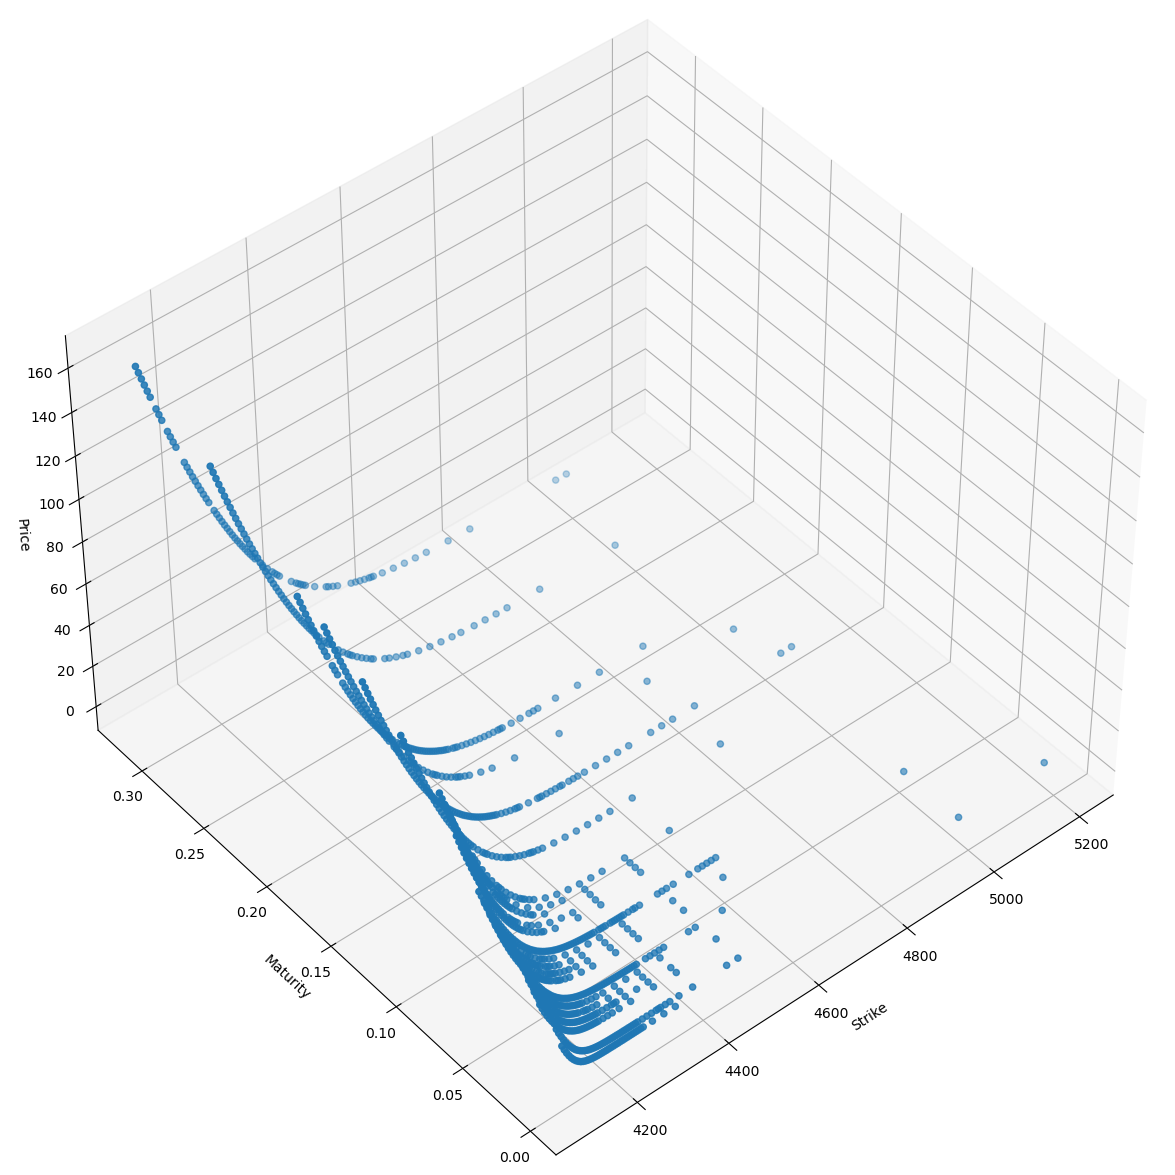

In [52]:
df_price = pd.read_csv("spx_4.csv", index_col=0)
#Filtrer les SPX... qui ne sont pas des SPXW...
mask = df_price['Calls'].str.contains('SPXW', case=False, na=False)
df_price = df_price[mask]

#==================================================================================================================

callPrices = df_price[['Strike']] #['Last Sale','Strike']]
# Compute the mid-price
callPrices['Price'] = np.abs(df_price['Bid'].array + df_price['Ask'].array)/2
# Convert index to datetime
callPrices.index = pd.to_datetime(callPrices.index)

# Getting the weights inversely proportional to bid-ask spread
callPrices['w'] = np.abs(1/(df_price['Bid'].array - df_price['Ask'].array))

# define a function to compute the difference in days between two dates
def date_diff(date):
    diff = (date - start_date)
    return diff.days

# create a new column in the DataFrame that contains the difference in days
callPrices['Maturity'] = callPrices.index.to_series().apply(date_diff)
callPrices['Maturity'] = callPrices['Maturity']/252# trading days.../365.25
#callPrices['Strike'] = np.log(callPrices['Strike'].array)

callPrices = callPrices[callPrices['Strike']>=S0]

# drop today
callPrices = callPrices[callPrices['Maturity']!=0]
#579 avec zero mat included


putPrices = df_price[['Strike']] #['Last Sale','Strike']]
# Compute the mid-price
putPrices['Price'] = np.abs(df_price['Bid.1'].array + df_price['Ask.1'].array)/2
# Convert index to datetime
putPrices.index = pd.to_datetime(putPrices.index)

# Getting the weights inversely proportional to bid-ask spread
putPrices['w'] = np.abs(1/(df_price['Bid.1'].array - df_price['Ask.1'].array))

# define a function to compute the difference in days between two dates
def date_diff(date):
    diff = (date - start_date)
    return diff.days

# create a new column in the DataFrame that contains the difference in days
putPrices['Maturity'] = putPrices.index.to_series().apply(date_diff)
putPrices['Maturity'] = putPrices['Maturity']/365.25
#callPrices['Strike'] = np.log(callPrices['Strike'].array)

putPrices = putPrices[putPrices['Strike']<=S0]

# drop today
putPrices = putPrices[putPrices['Maturity']!=0]
#579 avec zero mat included

#==================================================================================================================
# create 3D scatter plot
fig = plt.figure(figsize= [15,15])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(callPrices['Strike'], callPrices['Maturity'], callPrices['Price'])#,s=50)
#ax.plot_surface(callPrices['Strike'], callPrices['Maturity'], callPrices['Price'], cmap=cm.coolwarm)
ax.view_init(elev=45, azim=230)
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price')

plt.show()

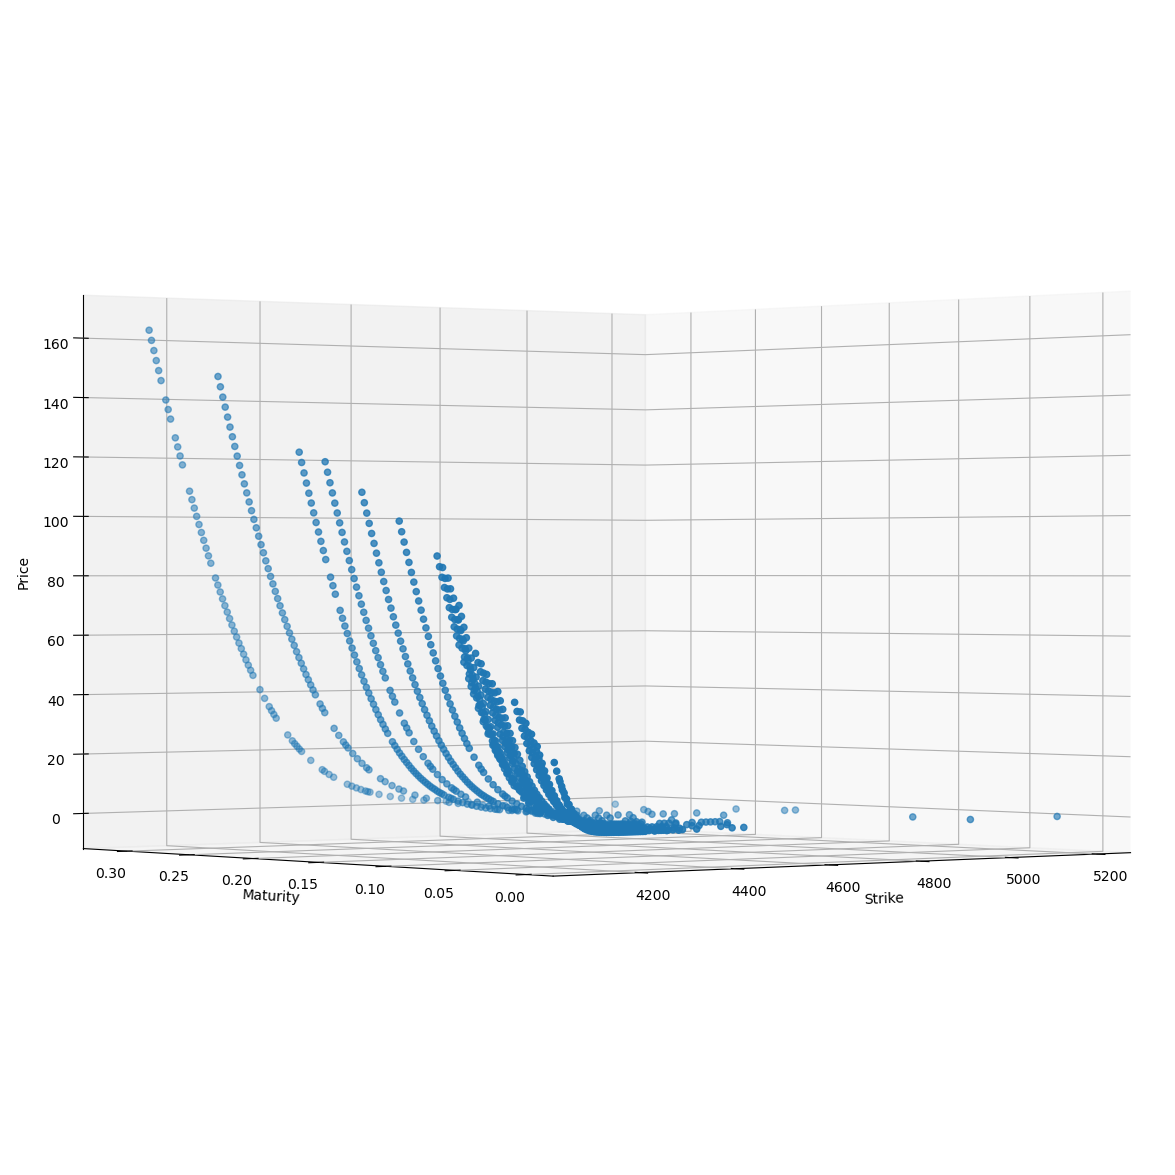

In [53]:
# create 3D scatter plot
fig = plt.figure(figsize= [15,15])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(callPrices['Strike'], callPrices['Maturity'], callPrices['Price'])#,s=50)
#ax.plot_surface(callPrices['Strike'], callPrices['Maturity'], callPrices['Price'], cmap=cm.coolwarm)
ax.view_init(elev=0, azim=230)
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price')

plt.show()

In [54]:
### Building the marketprice matrix

In [55]:
strikes = pd.Series(callPrices['Strike'].unique()).sort_values().to_list()
maturities = pd.Series(callPrices['Maturity'].unique()).sort_values().to_list()
lenK = len(strikes)
lenT = len(maturities)

strike_m = []

#for i in strikes: 
for j in maturities: 
        #print(i, j)
        strike_m_temp = callPrices[(callPrices['Maturity']==j)]['Strike'].to_list()
        #marketPrices_temp = callPrices[(callPrices['Maturity']==j)]['Price'].to_list()
        
        #marketPrices.append(marketPrices_temp)
        strike_m.append(strike_m_temp)
        
strikes = set(strike_m[0])
for i in range(1,len(strike_m)):
    strikes = strikes.intersection(set(strike_m[i]))

strikes = list(strikes)
strikes = sorted(strikes)
print(strikes)

marketPrices = np.zeros((len(strikes), len(maturities)))
w = np.zeros((len(strikes), len(maturities)))
for j in range(len(maturities)):
    for i in range(len(strikes)):
        #print(maturities[j])
        #print(strikes[i])
        #print(callPrices[(callPrices['Maturity']== maturities[j]) & (callPrices['Strike']==strikes[i])]['Price'][0])
        marketPrices[i,j] = callPrices[(callPrices['Maturity']== maturities[j]) & (callPrices['Strike']==strikes[i])]['Price'][0]
        w[i,j] = callPrices[(callPrices['Maturity']== maturities[j]) & (callPrices['Strike']==strikes[i])]['w'][0]
        
marketPrices = marketPrices.T
w = w.T
#==================================================================================================================


strikes_p = pd.Series(putPrices['Strike'].unique()).sort_values().to_list()
maturities_p = pd.Series(putPrices['Maturity'].unique()).sort_values().to_list()
lenK_p = len(strikes_p)
lenT_p = len(maturities_p)

strike_m_p = []

#for i in strikes: 
for j in maturities_p: 
        #print(i, j)
        strike_m_temp_p = putPrices[(putPrices['Maturity']==j)]['Strike'].to_list()
        #marketPrices_temp = callPrices[(callPrices['Maturity']==j)]['Price'].to_list()
        
        #marketPrices.append(marketPrices_temp)
        strike_m_p.append(strike_m_temp_p)
        
strikes_p = set(strike_m_p[0])
for i in range(1,len(strike_m_p)):
    strikes_p = strikes_p.intersection(set(strike_m_p[i]))

strikes_p = list(strikes_p)
strikes_p = sorted(strikes_p)
#print(strikes_p)
#print(maturities_p)
marketPrices_p = np.zeros((len(strikes_p), len(maturities_p)))
w_p = np.zeros((len(strikes_p), len(maturities_p)))
for j in range(len(maturities_p)):
    for i in range(len(strikes_p)):
        #print(maturities_p[j])
        #print(strikes_p[i])
        #print(putPrices[(putPrices['Maturity']== maturities_p[j]) & (putPrices['Strike']==strikes_p[i])]['Price'][0])
        marketPrices_p[i,j] = putPrices[(putPrices['Maturity']== maturities_p[j]) & (putPrices['Strike']==strikes_p[i])]['Price'][0]
        w_p[i,j] = putPrices[(putPrices['Maturity']== maturities_p[j]) & (putPrices['Strike']==strikes_p[i])]['w'][0]
        
marketPrices_p = marketPrices_p.T
w_p = w_p.T

[4105, 4110, 4120, 4125, 4130, 4140, 4150, 4170, 4190, 4200, 4210, 4220, 4225, 4230, 4250, 4275, 4300]


In [56]:
# function for the search: 
def myRange(start, finish, increment):
    while (start <= finish):
        yield start
        start += increment
        
def objFunc(v, x0, x1, x2):
    # Paraboloid centered on (x, y), with scale factors (10, 20) and minimum 30
    return 10.0*(v[0]-x0)**2 + 20.0*(v[1]-x1)**2 + 30.0*(v[2]-x2)**2 + 40.0

In [ ]:
#params2 = xopt
lenT = len(maturities)
lenK = len(strikes)
modelPrices = np.zeros((lenT, lenK))

print('lenT', lenT)
print('lenK', lenK)


for i in range(lenT):
    for j in range(lenK):
        T = maturities[i]
        K = strikes[j]
        #[km, cT_km] = mfc.genericFFT(params2, S0, K, r, q, T, alpha, eta, n, model)
        #modelPrices[i,j] = cT_km[0]
        modelPrices[i,j] = pricer_ed(S0, numPaths, T, K, dt, m)
        


# plot
fig = plt.figure(figsize=(10,8))
labels = []
colormap = cm.Spectral
# create a list of colors to cycle through
colors = [colormap(i) for i in np.linspace(0, 0.9, len(maturities))]

#plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, len(maturities))])
plt.gca().set_prop_cycle(color=colors)
for i in range(len(maturities)):
    plt.plot(strikes, marketPrices[i,:], 'x')
    labels.append('T = ' + str(maturities[i]))
    
for i in range(len(maturities)):
    plt.plot(strikes, modelPrices[i,:], '+')
    labels.append('T = ' + str(maturities[i]))
plt.legend(labels, loc='upper right', ncol=2)
plt.grid(alpha=0.25)
plt.xlabel('Strike')
plt.ylabel('Price')
plt.title('Market vs. Model using BFGS and Heston model (with equal weights)')
plt.savefig('MarketvsModel_BFGS.png')
plt.show() 

lenT 23
lenK 17
[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.71it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.05it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.42it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.80it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.95it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.94it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.04it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.03it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.91it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.81it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.90it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.61it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.79it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.05it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.18it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.74it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.31it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.94it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.91it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.56it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.93it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.68it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.04it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.85it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.07it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.22it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.74it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.71it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.06it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.87it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.03it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.18it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.95it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.82it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.42it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.03it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.82it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.04it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.92it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.01it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.14it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.21it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.01it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.17it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.05it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.80it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.05it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.88it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.10it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.06it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.85it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.13it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.72it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.08it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.10it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.93it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.11it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.01it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.03it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.62it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.96it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.92it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.03it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.05it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.73it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.00it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.08it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.91it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.82it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.09it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.01it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.98it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.96it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.73it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.80it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.90it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.90it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.96it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.92it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.04it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.07it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.80it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.96it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.58it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.15it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.02it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.79it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.93it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.12it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.08it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.52it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.99it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.92it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.07it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.05it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.88it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.73it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.02it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.98it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.97it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.93it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.00it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.00it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.86it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.99it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.97it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.86it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.09it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.75it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.04it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.53it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.10it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.11it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.09it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.99it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.04it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.01it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.03it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.86it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.97it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.04it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.54it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.03it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.01it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.05it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.87it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.70it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.60it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.99it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.04it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.76it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.11it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.02it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.07it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.83it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.84it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.90it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.01it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.08it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.67it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.91it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.88it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.07it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.88it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.73it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.88it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.59it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.99it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.67it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.94it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.88it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.88it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.88it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.12it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.06it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.61it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.55it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.24it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.49it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.16it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.47it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.64it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.21it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.54it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.22it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.42it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.11it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.90it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.30it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.53it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.63it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.44it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.30it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.32it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.41it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.48it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.25it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.43it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.39it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.50it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.42it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.28it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.52it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.45it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.53it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.25it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.42it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.45it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.40it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.20it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.47it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.55it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.49it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.45it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.02it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.60it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.48it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.66it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.55it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.47it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.56it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.56it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.64it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.22it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.55it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.25it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.58it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.57it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.32it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.50it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.34it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.42it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.31it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.31it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.58it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.28it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.44it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.25it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.53it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.59it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.59it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.05it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.30it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.76it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.52it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.33it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.57it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.44it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.50it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.93it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.28it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.39it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.43it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.49it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.32it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.07it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.45it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.49it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.55it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.11it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.65it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.60it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.55it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.39it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.21it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.52it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.65it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.51it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.34it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.27it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.55it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.55it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.56it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.27it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.51it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.47it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.59it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.65it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.37it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.31it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.66it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.57it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.52it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.04it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.51it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.64it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.62it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.45it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.63it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.58it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.69it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.68it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.63it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.09it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.62it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.36it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.68it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.10it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.39it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.58it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.63it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.20it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.44it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.32it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.49it/s]


[*********************100%***********************]  1 of 1 completed
3062


100%|██████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.60it/s]


[*********************100%***********************]  1 of 1 completed
3062


In [ ]:
# create a meshgrid of the maturities and strikes
maturities_, strikes_ = np.meshgrid(maturities, strikes)

maturities_flat = maturities_.flatten()
strikes_flat =  strikes_.flatten()
prices_flat =  marketPrices.flatten()


fig = plt.figure(figsize= [15,15])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(strikes_flat, maturities_flat, modelPrices.T, label='Heston with BFGS (with equal weights)')
ax.scatter(strikes_, maturities_, marketPrices.T, label='Market')
ax.view_init(elev=45, azim=230)
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price')
ax.set_title('Market vs. Model using BFGS and Heston model (with equal weights)')
plt.legend()

plt.show()